<a href="https://colab.research.google.com/github/averkief/My_Date_Analytics/blob/main/Popular_Russian_syllables.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

***Предисловие***<br>
Когда мой сын подрастал и начинал познавать мир, то дошло дело и до чтения.
Современные методики рекомендуют учить детей не буквам, а слогам. Указывая на то, что так будет проще научиться читать.<br>
И так в русском языке 10 гласных букв и 20 согласных. Отбросив соединения согласных с гласными которые не соответсвуют правилам русского языка, получаем 158 правильных слогов.<br>
И тут у меня возник вопрос, а какие слоги самые популярные, какие лучше выучить первыми???<br><br>
ИТАК ЗАДАЧА: Какой слог встречается чаще всего? И бонусом, какая длина чаще всего у этих слов?

**Последовательность действий**<br>
*Этап 1: Подключение к источнику и получение текста книги*<br>
Выбор книги выпал на "Война и Мир" Л.Н.Толстова, как самая большая по объему. Текст книги есть в интернете. Требуется спарсить текст с сайта<br>
*Этап 2: Получение текста, его обрабока и перевод в строку* <br>
Разбиваем текст на слова и извлекаем пунктуацию, предлоги, местоимения слова не относящиеся к словам со слогами<br>
*Этап 3: Внесение данных для нахождения слогов* <br>
Подготовка искомых слогов и счетчиков подсчета<br>
*Этап 4: Заготовка Дата-Фрейма* <br>
Создаем основу ДатаФрема с нулевыми значениями<br>
*Этап 5: Обрабока слов и учет количество слогов* <br>
Обработка каждого слова<br>
Ссылка на dataframe csv:<br>
https://drive.google.com/drive/folders/198CcQ6XPT9pYd3yzQ5QDDwN5IMZRp1pf?usp=sharing<br>
*Этап 6: Анализ полученных данных* <br>
Получение информации: количественное значиени, графики<br>

### Подключение библиотек и глобальных переменных

In [1]:
!pip install plotly # Библиотеки графиков

In [2]:
import requests # Бибилиотека запросов к web-сервисам
from bs4 import BeautifulSoup as bs # Библиотека парсинга web-страниц
import pandas as pd # Библиотека для работы с таблицами
import numpy as np

# Для обработки текста
import nltk # Библиотека для работы с текстом
from nltk.tokenize import word_tokenize # токенайзер - разбивает непрерывный текст на токены(слова). word_tokenize - для разделения слов на токены.
#nltk.download('all')
nltk.download('punkt')
#nltk.download('stopwords')

import string # используем для получения знаков пунктуации

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [3]:
# Библиотеки графиков
import plotly
import plotly.graph_objs as go
import plotly.express as px
from plotly.subplots import make_subplots

In [4]:
# Глобальные переменные
URL = 'https://ilibrary.ru' # + index.html - Страница оглавления книг "Война и Мир"
URL_CHAPTER  = '/text/11/index.html' # страница оглавления
URL_ENDINGS = [] # Список окончаний url страниц книги
TEXT_BOOK = '' # Полный текст (все слова больше 2 букв) для анализа слогов
TOTAL_SLOG = [] # Основа датафрейма из всех возможные варианты слогов, даже те которые противоречат поравилам русского языка
vowels = 'ауоыиэяюёе' # гласные буквы
consonants = 'бвгджзклмнпрстфхцчшщ' # согласные буквы

### Этап 1: Подключение к источнику

In [5]:
# Подключение к странице оглавления
connect_url = requests.get(URL + URL_CHAPTER)
if connect_url.status_code == 200:
  text_in_page = connect_url.text
else:
  print('СТРАНИЦА НЕ ДОСТУПНА')

In [6]:
# Функция проверка существующей ссылки
def check_href(href_url):
  ''' Проверка значение с пердидущим значением списка'''
  #global URL_ENDINGS

  if len(URL_ENDINGS) < 1:
    URL_ENDINGS.append(href_url)
  else:
    if href_url != URL_ENDINGS[-1]:
      URL_ENDINGS.append(href_url)

In [7]:
# Получение всех страниц книги
chapter_page = bs(text_in_page, 'html.parser')
href_to_url = chapter_page.find_all('p')
for href_one in href_to_url:
  check_href(href_one.a['href'])

# Проверка количества стра быниц в списке, должноть 361
print(len(URL_ENDINGS))   # содержание ['/text/11/p.1/index.html', '/text/11/p.2/index.html', '/text/11/p.3/index.html',...,'/text/11/p.361/index.html']

361


#### Этап 2: Получение текста, его обрабока и перевод в строку

In [8]:
# Списки пунктуации и стоп-слов (предлоги, местоимения и т.п.)
my_stop_punct = list(string.punctuation)
my_stop_punct = set(my_stop_punct + ['—'] + ['..'] + ['...'] + ['«'] + ['»'])
my_stop_not_words = {'abc', 'abcdefghiklmnopqrstuvwxyz', '123456789102030405060708090100110120130140150160'} # несуществующие слова, возможно защита сайта от копирования текста, найдены эмпирически
my_stop_words = {'а',
                 'без', 'бы', 'будто', 'был', 'была', 'было', 'более',
                 'в', 'во', 'вы', 'все', 'всю', 'вас', 'вам', 'всех',
                 'где', 'го',
                 'да', 'до', 'для',
                 'его', 'ее', 'её', 'еще', 'ещё', 'ему', 'ей', 'есть',
                 'ж', 'же',
                 'за', 'зачем',
                 'и', 'их', 'из', 'или', 'им',
                 'к', 'ко', 'как', 'кто', 'какой', 'какая', 'куда',
                 'ли',
                 'мы', 'мне', 'меня', 'моя', 'мой',
                 'не', 'ни', 'на', 'но', 'ну', 'нет', 'него', 'ней', 'нее', 'них', 'нами', 'нас', 'над', 'ним', 'нибудь',
                 'о', 'он', 'она', 'они', 'от', 'об',
                 'по', 'при', 'под', 'потому', 'после', 'про',
                 'раз', 'разве',
                 'с', 'со', 'сам', 'себе', 'свою',
                 'то', 'ты', 'та', 'те', 'так', 'тот', 'тем', 'там', 'тут', 'тебя', 'тоже', 'того', 'том', 'такой',
                 'у', 'уж', 'уже',
                 'хоть',
                 'что', 'чем', 'чтоб', 'чего', 'чуть', 'чтобы',
                 'это', 'эти', 'эту', 'этот', 'этого', 'этой', 'этом',
                 'я'}

In [9]:
def text_processing(text):
  ''' Принимает сырой текст, фильтрует его от знаков пунктуации, несуществущих слов и переводит в нижний регистр'''

  words = word_tokenize(text.lower()) # Разбмваем на список слов (токены)
  words = [word for word in words if word not in my_stop_punct] # Удаляем знаки пунктуации
  words = [word for word in words if word not in my_stop_not_words] # Удаляем стопслова

  all_words = ';'.join(words)
  return all_words

In [10]:
%%time
# Получение текта книги с каждой страницы
for URL_ENDING in URL_ENDINGS:
#for URL_ENDING in URL_ENDINGS[248:250]: # для тестов выберем несколько страниц
  print(URL + URL_ENDING) # Получаем ссылку к которой обратились за текстом книги
  connect_url_page = requests.get(URL + URL_ENDING)
  if connect_url_page.status_code == 200:
    text_page = connect_url_page.text
    one_page = bs(text_page, 'html.parser')
    text_in_url = one_page.find_all('span', class_='p')
    for text_one in text_in_url:
      TEXT_BOOK = TEXT_BOOK + text_processing(text_one.text) + ';' # Текст в функцию передается построчно до красной строки, так постепенно каждым абзацем наполняем полный текст

  else:
    print('ALARM!!! Ошибка подключения к странице сайта')

https://ilibrary.ru/text/11/p.1/index.html
https://ilibrary.ru/text/11/p.2/index.html
https://ilibrary.ru/text/11/p.3/index.html
https://ilibrary.ru/text/11/p.4/index.html
https://ilibrary.ru/text/11/p.5/index.html
https://ilibrary.ru/text/11/p.6/index.html
https://ilibrary.ru/text/11/p.7/index.html
https://ilibrary.ru/text/11/p.8/index.html
https://ilibrary.ru/text/11/p.9/index.html
https://ilibrary.ru/text/11/p.10/index.html
https://ilibrary.ru/text/11/p.11/index.html
https://ilibrary.ru/text/11/p.12/index.html
https://ilibrary.ru/text/11/p.13/index.html
https://ilibrary.ru/text/11/p.14/index.html
https://ilibrary.ru/text/11/p.15/index.html
https://ilibrary.ru/text/11/p.16/index.html
https://ilibrary.ru/text/11/p.17/index.html
https://ilibrary.ru/text/11/p.18/index.html
https://ilibrary.ru/text/11/p.19/index.html
https://ilibrary.ru/text/11/p.20/index.html
https://ilibrary.ru/text/11/p.21/index.html
https://ilibrary.ru/text/11/p.22/index.html
https://ilibrary.ru/text/11/p.23/index.ht

In [11]:
list_TEXT_BOOK = TEXT_BOOK.split(';') # переведем в список для обрабоки
quantity_words_in_text = len(list_TEXT_BOOK) # Сколько всего обрабатывается слов
print(f'Количество слов в тексте: {quantity_words_in_text}')

Количество слов в тексте: 460984


In [12]:
#Определить самое длинное слово
max_word_in_text = max(list_TEXT_BOOK, key=len)
max_len_word_in_text = len(max_word_in_text)
# добавить суда проверку дефиса
print(f'Самое длинное слово из полного текста: "{max_word_in_text}", состоит из: {max_len_word_in_text} букв')

Самое длинное слово из полного текста: "сверхъестественно-прекрасное", состоит из: 28 букв


In [13]:
# ПРОВЕРКА длинных слов
for long_word in list_TEXT_BOOK:
  if len(long_word) > 20:
    print(long_word)

сверхъестественно-прекрасное
сверхъестественно-утонченное
двенадцать-тринадцать
характерно-благородными
медленно-торжественно
натянуто-неестественное
легкомысленно-веселый
хофс-кригс-вурст-шнапс-рат
высокопревосходительство
высокопревосходительство
товарищами-сослуживцами
раздраженно-оживленными
однообразно-разнообразными
оригинально-остроумными
оживленно-недовольный
высокопревосходительство
высокопревосходительство
кавалериста-полковника
необыкновенно-торжественно
испуганно-вопросительно
неприятно-растерянным
добродушно-победительным
непонятно-привлекательное
задушевно-поэтический
вопросительно-сердитый
вопросительно-грустно
хлопотливо-возбужденное
всемирно-исторической
первично-размягченном
высокопревосходительство
высокопревосходительство
высокопревосходительство
восторженно-испуганное
восторженно-влюбленных
восторженно-озлобленными
значительно-спокойным
деятельно-добродетельной
поучительно-наставническую
религиозно-благодарственные
трогательно-благодарным
мерзавцу-протоколисту
обер

In [14]:
# ПРОВЕРКА слов на наличие дефисов
pp = 0
for dash_word in list_TEXT_BOOK:
  if '-' in dash_word:
    print(dash_word)
    pp += 1
print(pp)

dites-moi
из-за
a-t-on
a-t-on
что-то
особенно-небрежно
l'impératrice-mère
l'impératrice-mère
voulez-vous
что-то
неожиданно-грубое
voulez-vous
почему-то
arrangez-moi
покой-ер-п
императрице-матери
dites-moi
из-за
чего-нибудь
что-то
что-то
что-нибудь
чего-нибудь
все-таки
сверхъестественно-прекрасное
что-то
сверхъестественно-утонченное
contez-nous
чем-то
contez-nous
чем-то
что-либо
attendez-moi
pensez-vous
apportez-moi
сестрою-красавицею
из-за
темно-зеленом
m-lle
это-то
что-то
это-то
притворно-сладкое
aide-de-camp
m-lle
неожиданно-доброй
что-то
когда-то
что-то
что-нибудь
когда-то
по-итальянски
croyez-moi
что-то
что-нибудь
по-английски
по-русски
по-русски
по-русски
что-нибудь
что-то
по-новому
па-звольте
сухо-неприятно
по-русски
savez-vous
по-моему
что-нибудь
что-нибудь
гувернером-аббатом
что-нибудь
это-то
по-французски
флигель-адъютантом
капризно-игривым
кто-то
из-за
все-таки
что-нибудь
чего-нибудь
что-то
все-таки
voulez-vous
что-нибудь
что-то
что-нибудь
ну-ка
по-французски
по-английски
по-

In [15]:
# ПРОВЕРКА слов на наличие символов
ppp = 0
for dash_word in list_TEXT_BOOK:
  for symbol in my_stop_punct:
    if symbol in dash_word:
      print(dash_word)
      ppp += 1
print(ppp)

Выходные данные были обрезаны до нескольких последних строк (5000).
то-то
j'ai
как-то
выслали-таки
где-то
что-то
чему-то
из-под
какое-нибудь
3.
гостьи-барышни
соня-племянница
из-под
дружба-то
дружба-то
гостью-барышню
гостью-барышню
страстно-озлобленно
секреты-то
двенадцать-тринадцать
что-нибудь
все-таки
что-то
шапкой-невидимкой
что-то
из-за
из-за
по-видимому
n'est
кого-нибудь
такого-то
что-нибудь
что-то
что-нибудь
все-таки
как-то
такая-то
из-под
все-таки
что-нибудь
чья-то
по-французски
из-под
m'avez
по-домашнему
c'est
c'est
c'est
n'ai
s'est
qu'on
c'est
c'est
d'un
d'arriver
j'imagine
все-таки
c'est
2.
l'angleterre
кого-то
па-де-кале
m-me
m-me
чего-нибудь
что-нибудь
что-нибудь
виновата-с
то-то
чем-то
из-под
гостей-мужчин
l'état
нет-с
чем-нибудь
кого-то
по-русски
именинно-сиявшей
поди-ка
притворно-тихим
поди-ка
отцу-то
тебе-то
из-за
из-за
из-за
что-то
гувернер-немец
l'autriche
почему-то
3.
умэр-р-рэт
мо-о-ож-но
мо-о-ожно
c'est
детски-грудной
капризно-весело
что-нибудь
у-у-у
ей-богу
вот-во

### Этап 3: Внесение данных для нахождения слогов

In [16]:
# Получим возможные слоги
for i in range(2):     # Костыль, чтоб создать 2 раза список из слогов, для разделения обработки полного текста и сокращенного
  for consonant in consonants:
    for vowel in vowels:
      TOTAL_SLOG.append([consonant + vowel]) # Создали список с вложенным (2 уровня) списком слогов.
#Вывод [['ба'], ['бу'], ['бо'], ['бы'], ['би'], ['бэ'], ['бя'], ['бю'], ... , ['щё'], ['ще']]

In [17]:
len_TOTAL_SLOG = len(TOTAL_SLOG)

for quan_slog in range(len_TOTAL_SLOG):
  if quan_slog < (len_TOTAL_SLOG / 2):
    TOTAL_SLOG[quan_slog].insert(0, 'Полный') # Дополняем вложенный список типом текста Первую половину слогов
  else:
    TOTAL_SLOG[quan_slog].insert(0, 'Сокращенный') # Дополняем вложенный список типом текста Вторую половину слогов
  TOTAL_SLOG[quan_slog].append(0) # Дополняем вложенный список нулевыми значениями совпадений слогов

#Вывод [['Полный', 'ба', 0], ['Полный', 'бу', 0], ['Полный', 'бо', 0], ['Полный', 'бы', 0], ... , ['Сокращенный', 'щё', 0], ['Сокращенный', 'ще', 0]]

### Этап 4: Заготовка Дата-Фрейма

In [18]:
DF_SLOG = pd.DataFrame(TOTAL_SLOG, columns=['Текст', 'Слог', 'Частота']) # Сформируем предварительный датафрейм, 0 - тип текста, 1 - слог, 2 - количество совпадений

In [19]:
#Добавляем колонки справа столько сколько возможно максимальное слово, т.е. от 2 до 28. Заполняем их 0, чтоб потом вести счетчик подсчета
for num in range(2, max_len_word_in_text + 1):
  DF_SLOG[f'{num} буквы'] = 0

In [20]:
DF_SLOG.shape

(400, 30)

In [21]:
DF_SLOG # Заготовка ДатаАрейма готова

,Текст,Слог,Частота,2 буквы,3 буквы,4 буквы,5 буквы,6 буквы,7 буквы,8 буквы,...,19 буквы,20 буквы,21 буквы,22 буквы,23 буквы,24 буквы,25 буквы,26 буквы,27 буквы,28 буквы
0,Полный,ба,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Полный,бу,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Полный,бо,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Полный,бы,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Полный,би,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,Сокращенный,щэ,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
396,Сокращенный,щя,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
397,Сокращенный,щю,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
398,Сокращенный,щё,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Этап 5: Обрабока слов и учет количество слогов

In [22]:
def word_processing(current_word, len_current_word):
  ''' Функция поиска слогов в слове '''

  for index_letter in range(1, len_current_word):

    if current_word[index_letter] in vowels and current_word[index_letter - 1] in consonants:  # Поиск слога в слове
      slog = current_word[index_letter - 1] + current_word[index_letter]

      find_index = DF_SLOG.loc[DF_SLOG.isin([slog]).any(axis=1)].index.tolist() # нахождение индекса в дата фрейме (номера строки) слога

      len_current_word_true = len_current_word
      if '-' in current_word:
        len_current_word_true = len_current_word - current_word.count('-') # поправка количества строк в слове
      if "'" in current_word:
        len_current_word_true -= current_word.count("'") # поправка количества строк в слове

      if len_current_word > 2 or ( current_word not in my_stop_words ):  # Если это слово от 3 букв и не входит в стоп слова
        DF_SLOG['Частота'][find_index[1]] += 1 # Увеличиваем число находжение слога в колонке частоты совпадений в Сокращенном тексте
        DF_SLOG[f'{len_current_word_true} буквы'][find_index[1]] += 1 # Увеличиваем число находжение слога в колонке длины слова где находится слог в Сокращенном тексте

      DF_SLOG['Частота'][find_index[0]] += 1 # Увеличиваем число находжение слога в колонке частоты совпадений в Полном тексте
      DF_SLOG[f'{len_current_word_true} буквы'][find_index[0]] += 1 # Увеличиваем число находжение слога в колонке длины слова где находится слог в Полном тексте


In [23]:
%%time
for word_from_list_book in list_TEXT_BOOK:
  if len(word_from_list_book) > 1:
    word_processing(word_from_list_book, len(word_from_list_book))

<ipython-input-22-bb7b75ec6c57>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  DF_SLOG['Частота'][find_index[1]] += 1 # Увеличиваем число находжение слога в колонке частоты совпадений в Сокращенном тексте
<ipython-input-22-bb7b75ec6c57>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  DF_SLOG[f'{len_current_word_true} буквы'][find_index[1]] += 1 # Увеличиваем число находжение слога в колонке длины слова где находится слог в Сокращенном тексте
<ipython-input-22-bb7b75ec6c57>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://p

CPU times: user 36min 13s, sys: 8.44 s, total: 36min 21s
Wall time: 36min 41s


In [24]:
DF_SLOG

,Текст,Слог,Частота,2 буквы,3 буквы,4 буквы,5 буквы,6 буквы,7 буквы,8 буквы,...,19 буквы,20 буквы,21 буквы,22 буквы,23 буквы,24 буквы,25 буквы,26 буквы,27 буквы,28 буквы
0,Полный,ба,2613,2,109,158,226,362,498,597,...,4,0,0,0,0,0,0,0,0,0
1,Полный,бу,2769,1,18,155,1171,283,185,107,...,1,0,1,1,0,0,0,0,0,0
2,Полный,бо,5891,2,207,343,1358,1047,1050,564,...,5,2,1,0,1,0,0,0,0,0
3,Полный,бы,10885,1514,1589,5227,1087,669,384,165,...,0,0,0,0,0,0,1,0,0,0
4,Полный,би,1947,0,17,101,261,312,484,394,...,0,1,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,Сокращенный,щэ,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
396,Сокращенный,щя,1,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
397,Сокращенный,щю,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
398,Сокращенный,щё,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [25]:
DF_SLOG.shape

(400, 30)

In [26]:
DF_SLOG_cleare = DF_SLOG.loc[DF_SLOG['Частота'] != 0] # отфильтруем ДатаФрей убрав слоги которые не встречаются
DF_SLOG_cleare.shape

(320, 30)

In [27]:
# Сохраняем ДатаФрейм для дальнейшей обработки, чтоб не выгружать его снова
DF_SLOG.to_csv('slog_sourse.csv', encoding="utf-8-sig")
DF_SLOG_cleare.to_csv('slog_cleare.csv', encoding="utf-8-sig")

### Этап 6: Анализ полученных данных

In [ ]:
!gdown --id 1lG_hMNm3WIHHYQSHNsY9NlkOMeK4ZntB

/usr/local/lib/python3.10/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1lG_hMNm3WIHHYQSHNsY9NlkOMeK4ZntB
To: /content/slog_cleare.csv
100% 33.2k/33.2k [00:00<00:00, 87.2MB/s]


In [28]:
# Загрузка датаФрейма
DF_SLOG_work = pd.read_csv('/content/slog_cleare.csv')
DF_SLOG_work.drop(columns='Unnamed: 0', axis= 1 , inplace= True ) # Удаление стобца с индексами

In [29]:
DF_SLOG_work

,Текст,Слог,Частота,2 буквы,3 буквы,4 буквы,5 буквы,6 буквы,7 буквы,8 буквы,...,19 буквы,20 буквы,21 буквы,22 буквы,23 буквы,24 буквы,25 буквы,26 буквы,27 буквы,28 буквы
0,Полный,ба,2613,2,109,158,226,362,498,597,...,4,0,0,0,0,0,0,0,0,0
1,Полный,бу,2769,1,18,155,1171,283,185,107,...,1,0,1,1,0,0,0,0,0,0
2,Полный,бо,5891,2,207,343,1358,1047,1050,564,...,5,2,1,0,1,0,0,0,0,0
3,Полный,бы,10885,1514,1589,5227,1087,669,384,165,...,0,0,0,0,0,0,1,0,0,0
4,Полный,би,1947,0,17,101,261,312,484,394,...,0,1,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
315,Сокращенный,що,2,0,0,0,0,2,0,0,...,0,0,0,0,0,0,0,0,0,0
316,Сокращенный,щи,1983,0,3,60,109,187,372,238,...,4,2,0,0,1,0,0,0,0,0
317,Сокращенный,щэ,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
318,Сокращенный,щя,1,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [30]:
DF_SLOG_work = DF_SLOG_work.sort_values(['Текст', 'Частота'], ascending=( True, False ))

In [31]:
DF_SLOG_work

,Текст,Слог,Частота,2 буквы,3 буквы,4 буквы,5 буквы,6 буквы,7 буквы,8 буквы,...,19 буквы,20 буквы,21 буквы,22 буквы,23 буквы,24 буквы,25 буквы,26 буквы,27 буквы,28 буквы
114,Полный,то,39641,2311,12056,3177,5938,4791,5731,1953,...,7,4,4,3,8,2,2,0,1,0
74,Полный,на,28610,6757,3530,2073,1896,3523,2579,2746,...,6,6,0,4,3,0,1,0,0,0
20,Полный,го,24155,6,4083,2683,2302,4252,2693,3475,...,14,5,1,5,1,0,0,1,0,0
83,Полный,не,24092,8754,2658,1575,654,1230,1629,1893,...,22,8,3,4,1,3,1,0,1,0
76,Полный,но,23335,2775,184,999,2645,2072,1860,3015,...,36,24,25,30,22,10,8,1,4,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
267,Сокращенный,сэ,1,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
287,Сокращенный,фэ,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
306,Сокращенный,чэ,1,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
317,Сокращенный,щэ,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [32]:
DF_FULL_work = DF_SLOG_work.loc[DF_SLOG_work['Текст'] == 'Полный'].head(30)
DF_SHORT_work = DF_SLOG_work.loc[DF_SLOG_work['Текст'] == 'Сокращенный'].head(30)

In [33]:
bar_tops = go.Figure()
bar_tops.add_trace(go.Bar(x=DF_FULL_work['Слог'], y=DF_FULL_work['Частота'], name='Полный'))
bar_tops.add_trace(go.Bar(x=DF_SHORT_work['Слог'], y=DF_SHORT_work['Частота'], name='Сокращенный'))
bar_tops.update_layout(title='Количество встечающихся слогов',
    title_x = 0.5,
    legend=dict(x=.5, xanchor="center", orientation="h"),
    margin=dict(l=0, r=0, t=30, b=0))
bar_tops.show()

In [34]:
# DF_SLOG_Analysis = pd.concat([DF_FULL_work, DF_SHORT_work]).reset_index(drop=True) # Объединяем датафреймы и сбрасываем индексы
DF_SLOG_Analysis = pd.concat([DF_FULL_work, DF_SHORT_work])

In [35]:
top_slogs = set(DF_SLOG_Analysis['Слог'])

In [36]:
quantity_letter_in_word = list(DF_SLOG_Analysis)[3:] # Количество букв в возможных словах ['2 буквы', '3 буквы', '4 буквы', ... , '27 буквы', '28 буквы']

In [37]:
quantity_letter_in_word

['2 буквы',
 '3 буквы',
 '4 буквы',
 '5 буквы',
 '6 буквы',
 '7 буквы',
 '8 буквы',
 '9 буквы',
 '10 буквы',
 '11 буквы',
 '12 буквы',
 '13 буквы',
 '14 буквы',
 '15 буквы',
 '16 буквы',
 '17 буквы',
 '18 буквы',
 '19 буквы',
 '20 буквы',
 '21 буквы',
 '22 буквы',
 '23 буквы',
 '24 буквы',
 '25 буквы',
 '26 буквы',
 '27 буквы',
 '28 буквы']

In [38]:
DF_SLOG_Analysis

,Текст,Слог,Частота,2 буквы,3 буквы,4 буквы,5 буквы,6 буквы,7 буквы,8 буквы,...,19 буквы,20 буквы,21 буквы,22 буквы,23 буквы,24 буквы,25 буквы,26 буквы,27 буквы,28 буквы
114,Полный,то,39641,2311,12056,3177,5938,4791,5731,1953,...,7,4,4,3,8,2,2,0,1,0
74,Полный,на,28610,6757,3530,2073,1896,3523,2579,2746,...,6,6,0,4,3,0,1,0,0,0
20,Полный,го,24155,6,4083,2683,2302,4252,2693,3475,...,14,5,1,5,1,0,0,1,0,0
83,Полный,не,24092,8754,2658,1575,654,1230,1629,1893,...,22,8,3,4,1,3,1,0,1,0
76,Полный,но,23335,2775,184,999,2645,2072,1860,3015,...,36,24,25,30,22,10,8,1,4,0
86,Полный,по,23285,1771,660,537,2378,2537,3236,3635,...,10,7,9,3,2,2,1,0,0,0
92,Полный,ра,22284,0,579,1290,1920,1646,3179,3376,...,18,5,8,7,11,1,3,0,1,0
50,Полный,ко,22141,112,24,322,2809,3553,7004,2168,...,5,10,8,1,8,10,1,0,0,0
78,Полный,ни,21110,893,1775,415,1193,1569,2934,3464,...,5,1,4,0,2,0,1,0,0,0
11,Полный,во,20205,585,655,1651,2809,2576,2758,2695,...,20,11,13,13,5,21,1,0,1,0


In [39]:
def length_word(index_slog):
  df_one_slog = DF_SLOG_Analysis.loc[[index_slog]].values
  return list(df_one_slog[0][3:])

In [40]:
%%time
length_word_zero = [0] * len(quantity_letter_in_word)
for slog in top_slogs:

  find_index_slog = DF_SLOG_Analysis.loc[DF_SLOG_Analysis.isin([slog]).any(axis=1)].index.tolist() # нахождение индекса в дата фрейме (номера строки) слога
  print(f'слог: {slog}, индексы {find_index_slog}')

  bar_word = go.Figure()
  if len(find_index_slog) == 1 and find_index_slog[0] < (len(DF_SLOG_work) / 2):
    bar_word.add_trace(go.Bar(x=quantity_letter_in_word, y=length_word(find_index_slog[0]), name='Полный'))
    bar_word.add_trace(go.Bar(x=quantity_letter_in_word, y=length_word_zero, name='Сокращенный'))
  elif len(find_index_slog) == 1 and find_index_slog[0] > (len(DF_SLOG_work) / 2):
    bar_word.add_trace(go.Bar(x=quantity_letter_in_word, y=length_word_zero, name='Полный'))
    bar_word.add_trace(go.Bar(x=quantity_letter_in_word, y=length_word(find_index_slog[0]), name='Сокращенный'))
  elif len(find_index_slog) == 2:
    bar_word.add_trace(go.Bar(x=quantity_letter_in_word, y=length_word(find_index_slog[0]), name='Полный'))
    bar_word.add_trace(go.Bar(x=quantity_letter_in_word, y=length_word(find_index_slog[1]), name='Сокращенный'))
  bar_word.update_layout(title=f'Длина слов где встечается слог "{slog}".',
      title_x = 0.5,
      legend=dict(x=.5, xanchor="center", orientation="h"),
      margin=dict(l=0, r=0, t=30, b=0))
  bar_word.show()

слог: ри, индексы [96, 256]


слог: ко, индексы [50, 210]


слог: бы, индексы [3, 163]


слог: но, индексы [76, 236]


слог: ро, индексы [94, 254]


слог: да, индексы [23, 183]


слог: ле, индексы [64, 224]


слог: се, индексы [111, 271]


слог: не, индексы [83, 243]


слог: ло, индексы [57, 217]


слог: ла, индексы [55, 215]


слог: го, индексы [20, 180]


слог: во, индексы [11, 171]


слог: мо, индексы [227]


слог: по, индексы [86, 246]


слог: до, индексы [25, 185]


слог: та, индексы [112, 272]


слог: ва, индексы [9, 169]


слог: на, индексы [74, 234]


слог: за, индексы [40, 200]


слог: те, индексы [121, 281]


слог: де, индексы [32, 192]


слог: ра, индексы [92, 252]


слог: ти, индексы [116, 276]


слог: ни, индексы [78, 238]


слог: же, индексы [39]


слог: ве, индексы [17, 177]


слог: ли, индексы [59, 219]


слог: то, индексы [114, 274]


слог: ка, индексы [48, 208]


слог: ре, индексы [101, 261]


CPU times: user 595 ms, sys: 13 ms, total: 608 ms
Wall time: 708 ms


Прочее

In [ ]:
DF_FULL_work.to_csv('slog_full_work.csv', encoding="utf-8-sig")

In [ ]:
DF_SHORT_work.to_csv('slog_short_work.csv', encoding="utf-8-sig")

In [ ]:
# Подумать над суммой слогов полного текста и сокращенного DF_FULL_work DF_SHORT_work
%%time
list_total_slog_full = list()
list_total_slog_short = list()
for tolal_slog in quantity_letter_in_word:
  sum_total_slog = DF_SLOG_Analysis[tolal_slog].sum()
  list_total_slog.append(sum_total_slog)

CPU times: user 2.27 ms, sys: 21 µs, total: 2.29 ms
Wall time: 2.31 ms


In [ ]:
DF_SLOG_Analysis

###Черновик

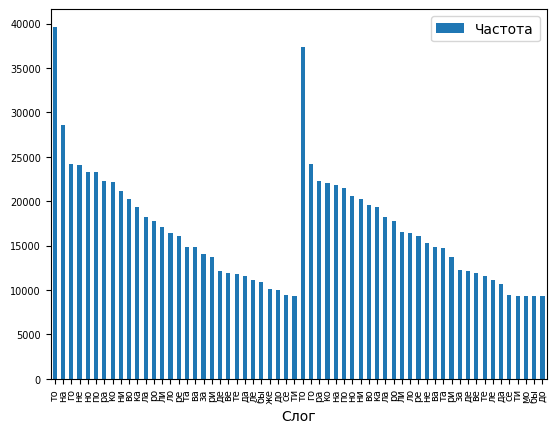

In [ ]:
DF_SLOG_Analysis.plot(x='Слог', y='Частота', kind="bar", rot=90, fontsize=7);

In [ ]:
DF_SLOG_work.groupby('Слог')['Частота'].mean()

Слог
ба    2613.0
бе    5682.0
би    1947.0
бо    5891.0
бу    2769.0
       ...  
щи    1983.0
що       2.0
щу     242.0
щэ       1.0
щя       1.0
Name: Частота, Length: 160, dtype: float64

In [ ]:
find_index = DF_SLOG.loc[DF_SLOG.isin(['вю']).any(axis=1)].index.tolist()

In [ ]:
find_index[1]